## Modelling Kobe

I was looking for a nice dataset to practice my feature engineering and modelling skills in python when I came across [the complete set of Kobe Bryant shots in the NBA](https://www.kaggle.com/c/kobe-bryant-shot-selection) in Kaggle. Being a long time NBA (and Kobe in particular) fan, I could not resist.

The task here then is to explore this beautiful dataset, identify which features are relevant and build a classification model with them in order to predict the outcome of each shot.


I will use these libraries:
* pandas for feature engineering
* seaborn for visualization
* sklearn for modelling

Let's start!

### Data loading

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
plt.style.use('seaborn')
sns.set_context('paper', font_scale=2)

In [2]:
folder = r'./kobe-bryant-shot-selection/'
data = pd.read_csv(folder + 'data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

Lots of features here, let's try to identify which ones we actually need and whether there are any redundancies.

In [3]:
data.sample(5)

action_type combined_shot_type  game_event_id   game_id  \
20431           Jump Shot          Jump Shot            258  21200716   
23975  Driving Layup Shot              Layup            117  29700813   
17144           Jump Shot          Jump Shot            155  21000535   
19428          Layup Shot              Layup            228  21200012   
16118  Fadeaway Jump Shot          Jump Shot            473  20900912   

           lat  loc_x  loc_y       lon  minutes_remaining  period   ...     \
20431  34.0443   -175      0 -118.4448                 11       3   ...      
23975  34.0443      0      0 -118.2698                  0       1   ...      
17144  33.9583     13     86 -118.2568                  6       2   ...      
19428  34.0443    -10      0 -118.2798                  5       2   ...      
16118  33.8473     28    197 -118.2418                  0       4   ...      

            shot_type shot_zone_area        shot_zone_basic  shot_zone_range  \
20431  2PT Field Goal   Left Side(L)              Mid-Range        16-24 ft.   
23975  2PT Field Goal      Center(C)        Restricted Area  Less Than 8 ft.   
17144  2PT Field Goal      Center(C)  In The Paint (Non-RA)         8-16 ft.   
19428  2PT Field Goal      Center(C)        Restricted Area  Less Than 8 ft.   
16118  2PT Field Goal      Center(C)              Mid-Range        16-24 ft.   

          team_id           team_name   game_date      matchup opponent  \
20431  1610612747  Los Angeles Lakers  2013-02-05    LAL @ BKN      BKN   
23975  1610612747  Los Angeles Lakers  1998-02-27    LAL @ MIN      MIN   
17144  1610612747  Los Angeles Lakers  2011-01-07  LAL vs. NOH      NOH   
19428  1610612747  Los Angeles Lakers  2012-10-31    LAL @ POR      POR   
16118  1610612747  Los Angeles Lakers  2010-03-04    LAL @ MIA      MIA   

       shot_id  
20431    20432  
23975    23976  
17144    17145  
19428    19429  
16118    16119  

[5 rows x 25 columns]

Let's plot the successfull and missed shots side by side. Here I followed [this guide](http://savvastjortjoglou.com/nba-play-by-play-movements.html) for the overlap with the court layout.

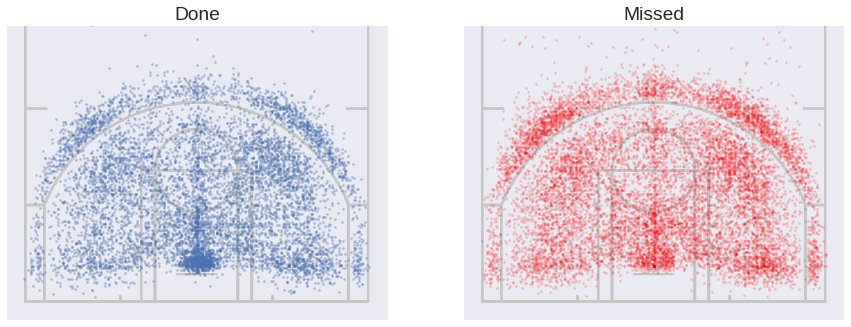

In [4]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
court = plt.imread(folder + "fullcourt.png")
court = np.transpose(court, (1, 0, 2))

made = data[data['shot_made_flag'] == 1]
ax1.imshow(court, zorder=0, extent=[-250, 250, 0, 940])
ax1.scatter(made['loc_x'], made['loc_y'] + 52.5, s=5, alpha=0.4)
ax1.set(xlim=[-275, 275], ylim=[-25, 400], aspect=1)
ax1.set_title('Done')
ax1.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)

missed = data[data['shot_made_flag'] == 0]
ax2.imshow(court, zorder=0, extent=[-250, 250, 0, 940])
ax2.scatter(missed['loc_x'], missed['loc_y'] + 52.5, s=5, color='red', alpha=0.2)
ax2.set(xlim=[-275, 275], ylim=[-25, 400], aspect=1)
ax2.set_title('Missed')
ax2.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)

f.gca().set_aspect('equal')
f.subplots_adjust(hspace=0)
plt.show()

They look nice but not too informative. I am interested in the areas where Kobe's effectivity is above and below his average, so let's try plotting that. We will need to group shots in small areas and take the mean in each one.

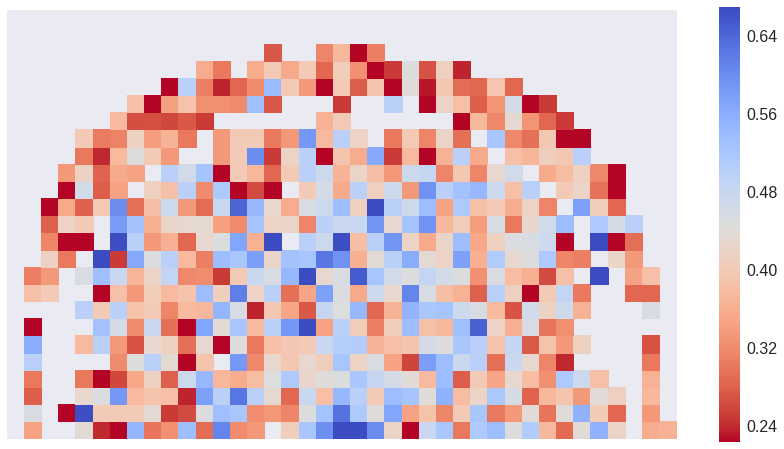

In [5]:
data['loc_x_step'] = pd.cut(data['loc_x'], np.linspace(-250, 250, 40))
data['loc_y_step'] = pd.cut(data['loc_y'], np.linspace(0, 470, 40))

steps_count = data.groupby(['loc_y_step', 'loc_x_step'])['shot_made_flag'].count().unstack()
grouped = data.groupby(['loc_y_step', 'loc_x_step'])['shot_made_flag'].mean().unstack()
grouped[steps_count < 10] = np.NaN
mean = data.shot_made_flag.mean()

plt.figure(figsize=(15, 8))
sns.heatmap(grouped, xticklabels=False, yticklabels=False, square=True, cmap='coolwarm_r', 
            vmin=0.5*mean, vmax=1.5*mean, center=data.shot_made_flag.mean())
plt.gca().invert_yaxis()
plt.ylim(0, 25)
plt.ylabel('')
plt.xlabel('')
plt.show()

This is better. We see the decrease with distance to the hoop and the empty space close to the three point line: when close to it, Kobe prefers to attempt the three point shot.

We drop columns with redundant location information:

* `lat, lon`
* `shot_zone_area`
* `shot_zone_range`
* `shot_zone_basic`
* `shot_distance`

They can all be represented more precisely with `[loc_x, loc_y]`. We will only keep the additional information of whether it was a 2PT or 3PT shot to account for hard to quantify psycological factors affecting the accuracy.

We also delete other redundant columns and those that do not offer relevant information for the purpose of model building (`['game_id', 'game_event_id', 'shot_id']`)

In [6]:
drop_columns = ['game_id', 'game_event_id', 'team_id', 'team_name', 'lat', 'lon', 'shot_zone_area', 
                'shot_zone_range', 'shot_zone_basic', 'shot_distance', 'shot_id']
data.drop(drop_columns, axis=1, inplace=True)

data['three_pointer'] = (data.shot_type.str[0] == '3').astype(int)
data.drop('shot_type', axis=1, inplace=True)

We don't know the outcome of 5000 shots, so we'll just delete those rows.

In [7]:
data = data[~data.shot_made_flag.isnull()]

### Exploratory analysis and feature selection

Here we will plot some features to recognize which ones we should consider when builing a classification model for Kobe's shots.

#### Shot type

Let's now look at the type of shot. First we count how many shots he took of each type. The dataset has two columns with this information: `action_type` and `combined_shot_type`.

/home/federico/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


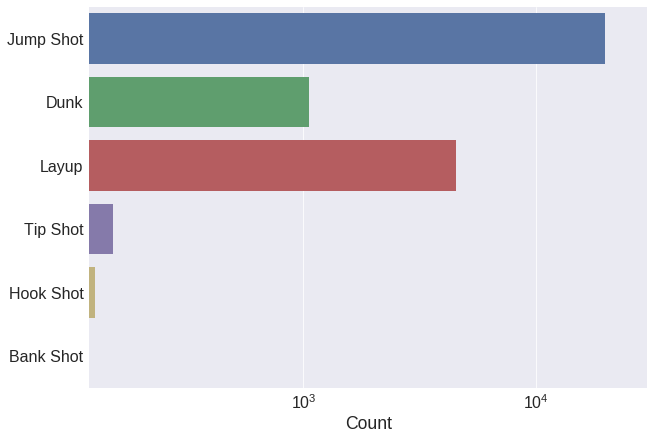

In [8]:
plt.figure(figsize=(10, 7))
sns.countplot(y='combined_shot_type', data=data, log=True)
plt.xlim(0, 30000)
plt.tick_params(axis='both', which='major')
plt.ylabel('')
plt.xlabel('Count')
plt.show()

/home/federico/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


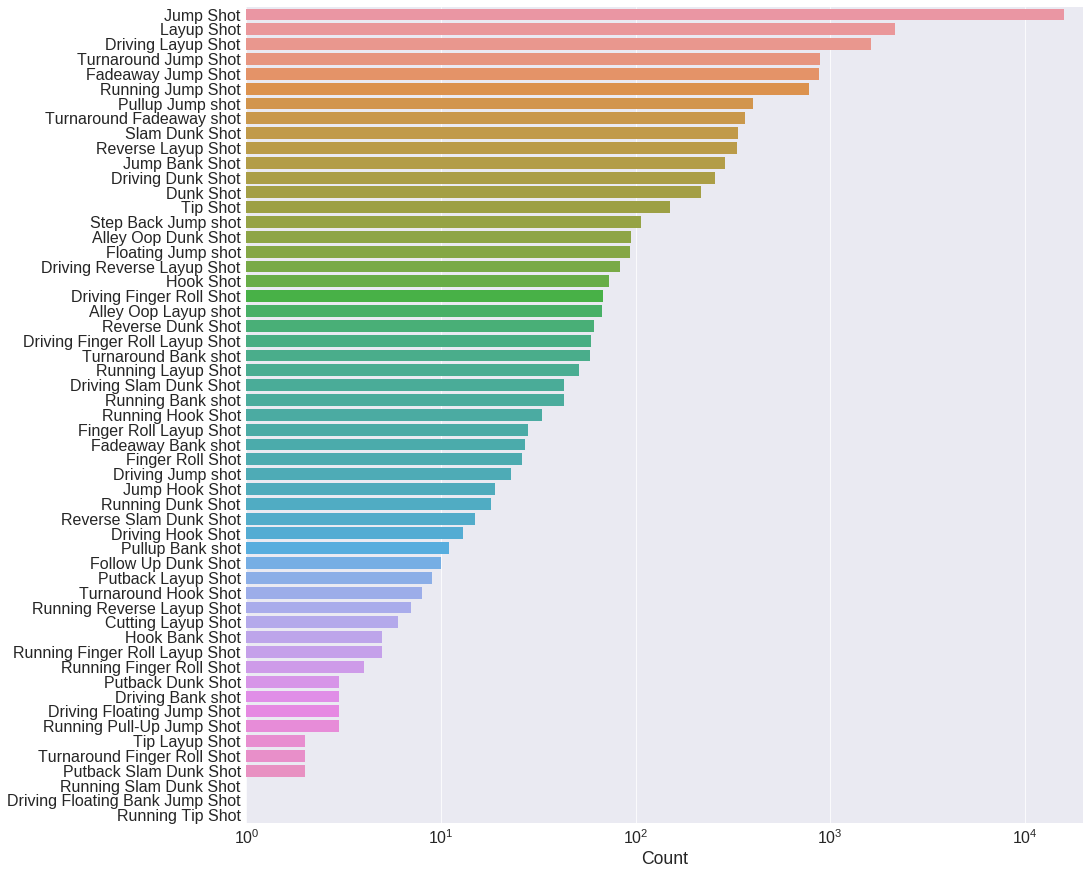

In [9]:
plt.figure(figsize=(15, 15))
sns.countplot(y='action_type', data=data, order=data['action_type'].value_counts().index, log=True)
plt.xlim(0, 20000)
plt.ylabel('')
plt.xlabel('Count')
plt.show()

Seems like `action_type` has a lot more information than `combined_shot_type`, because of the greater number of shot types. To avoid information redundancy, we only work with `action_type` then.

Notice the logscale in the previous plot: most shot califications have only a few counts. Shots that were seldom used by Kobe will have no predictive value whatsover. We decide then to replace all `action_type` values with less than 100 occurrencies by the name `Other`.

In [10]:
data.loc[data.groupby('action_type').action_type.transform('count').lt(100), 'action_type'] = 'Other'   
data.action_type = data.action_type.str.replace(' Shot', '', case=False)
data.drop('combined_shot_type', axis=1, inplace=True)

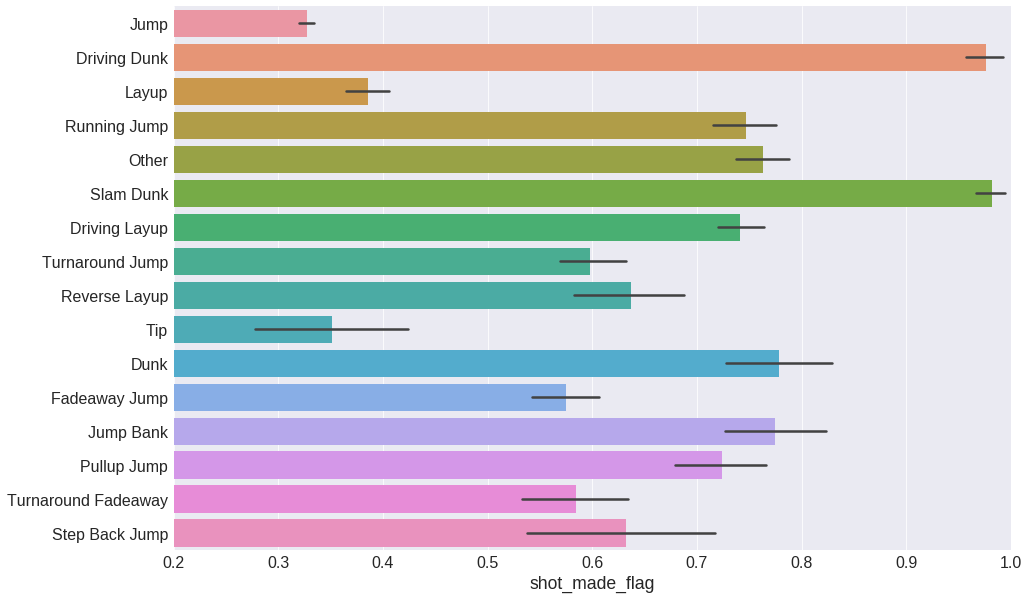

In [11]:
plt.figure(figsize=(15, 10))
sns.barplot(y='action_type', x='shot_made_flag', data=data)
plt.xlim(0.2, 1)
plt.ylabel('')
plt.show()

This already looks useful. Each kind of shot seems to have a distinct effectivity, and therefore `action_type` will be a good predictive feature for our model. We can now safely disregard `combined_shot_type`.

#### Timing

The timestamp of each shot spans several time scales:

* Season
* Date
* Whether the game was part of the NBA playoffs phase
* Game period
* Minutes and seconds remaining on the clock

We will take a look into each one to identify which features we need which ones we can drop.

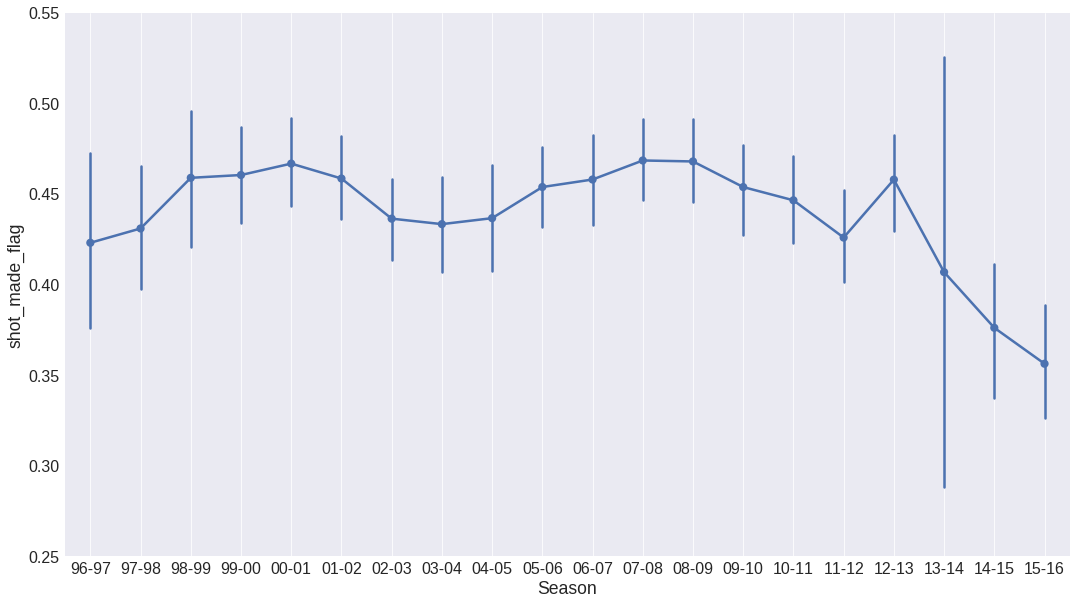

In [12]:
plt.figure(figsize=(18, 10))
sns.pointplot(x='season', y='shot_made_flag', data=data, order=sorted(list(data['season'].unique())))
plt.gca().set_xticklabels([x[2:] for x in sorted(list(data['season'].unique()))])
plt.gca().set_ylim(0.25, 0.55)
plt.xlabel('Season')
plt.grid()
plt.show()

The effectivity shows a very clear dependecy respect to the season. This means that the season will be a relevant feature for modelling. The big error bar for season 13-14 is due to the low number of shots Kobe took that year: he was injured during most of the season.

Also, let's replace the season by consecutive numbering starting on 0.

In [13]:
initialSeason = data.season.str[:4].astype(int).min()
data.season = data.season.str[:4].astype(int) - initialSeason

We can safely assume that the specific date does not affect the shot effectivity. Therefore, we only keep month information to catch more plausible seasonal effects. 

In [14]:
data['month'] = data['game_date'].str[5:7]
data.drop('game_date', axis=1, inplace=True) 

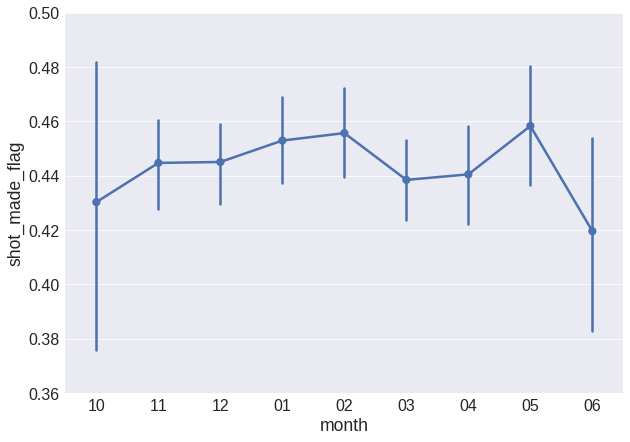

In [15]:
fig = plt.figure(figsize=(10, 7))
sns.pointplot(x='month', y='shot_made_flag', data=data, 
              order=['10', '11', '12', '01', '02', '03', '04', '05', '06'])
plt.ylim(0.36, 0.5)
plt.show()

Also, we need to fix the month order: some models will have a hard time dealing with the discontinuity between months 12 and 01. We will replace it for sequential numbering from the first month of the season, labeles as 0.

In [16]:
data.month.replace(data.month.unique(), np.arange(len(data.month.unique())), inplace=True)

Let's compare the effectivity of the regular and playoff phases.

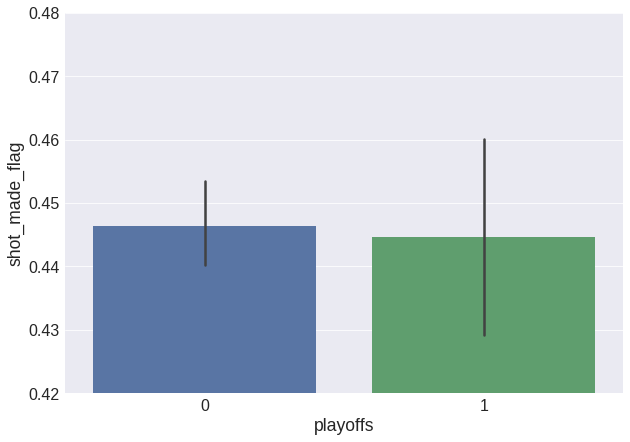

In [17]:
fig = plt.figure(figsize=(10, 7))
sns.barplot(x='playoffs', y='shot_made_flag', data=data)
plt.ylim(0.42, 0.48)
plt.show()

Whether the game is part of the playoffs phase does not seem to affect Kobe's shot effectivity. We can therefore remove this input feature from the dataset.

In [18]:
data.drop('playoffs', axis=1, inplace=True)

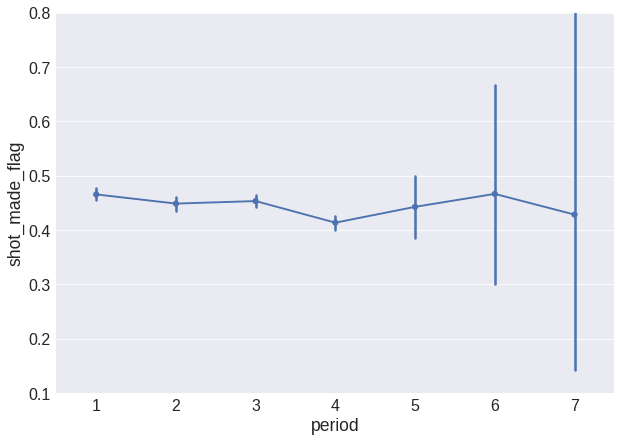

In [19]:
fig = plt.figure(figsize=(10, 7))
sns.pointplot(x='period', y='shot_made_flag', data=data, scale=0.75)
plt.ylim(0.1, 0.8)
plt.show()

The big error bars are due to the low number of shots taken from overtime periods. Let's merge the overtime periods into a single 5th period. 

/home/federico/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


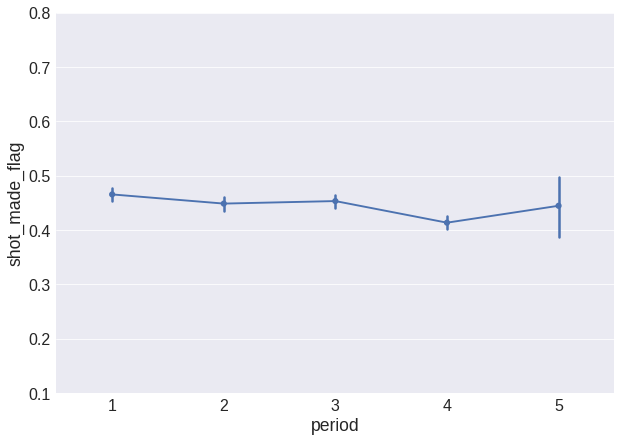

In [20]:
fig = plt.figure(figsize=(10, 7))
data.period.loc[data.period > 4] = 5
sns.pointplot(x='period', y='shot_made_flag', data=data, scale=0.75)
plt.ylim(0.1, 0.8)
plt.show()

`minutes_remaining` and `seconds_remaining` can be merged into a single feature that we will call `time_remaining` and we will measure in seconds

In [21]:
data['time_remaining'] = data.minutes_remaining*60 + data.seconds_remaining
data.drop(['minutes_remaining', 'seconds_remaining'], axis=1, inplace=True)

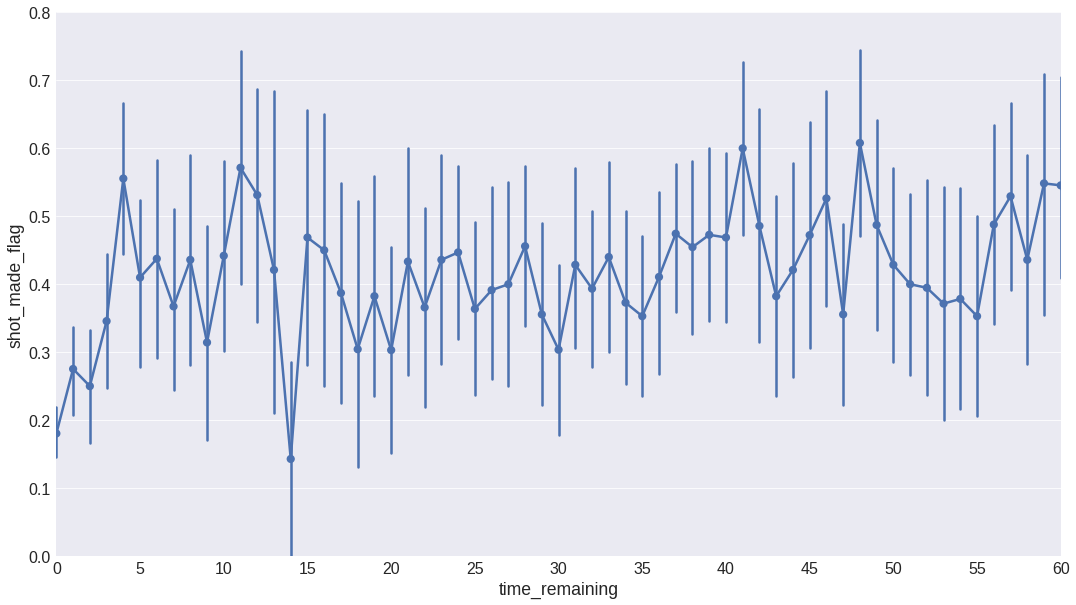

In [22]:
plt.figure(figsize=(18, 10))
sns.pointplot(x='time_remaining', y='shot_made_flag', data=data)
plt.xlim(0, 60)
plt.ylim(0, 0.8)
plt.xticks(np.arange(0, 65, 5), np.arange(0, 65, 5))
plt.show()

We see the effectivity is fairly constant except for the last couple of minutes shots. In order to keep this information while still reducing the number of features, we discretize `time_remaining` in `0, 1, 2, 3, 4`, where `4` also includes all shots taken with more than 4 seconds remaining on the clock.

/home/federico/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


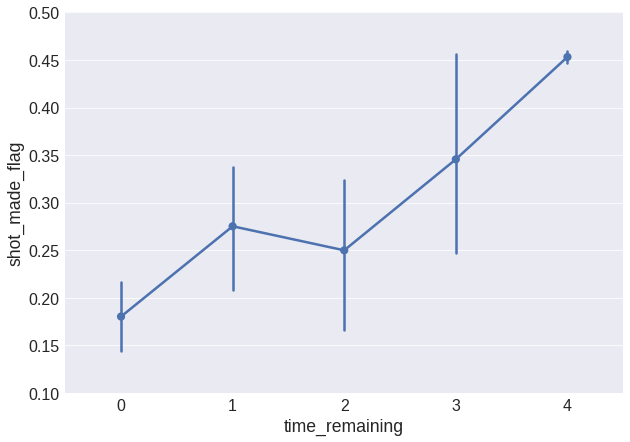

In [23]:
fig = plt.figure(figsize=(10, 7))
data.time_remaining.loc[data.time_remaining > 3] = 4
sns.pointplot(x='time_remaining', y='shot_made_flag', data=data)
plt.ylim(0.1, 0.5)
plt.show()

#### Location

Here we will explore

* Opponent
* Home vs away games
* Shot coordinates in the court

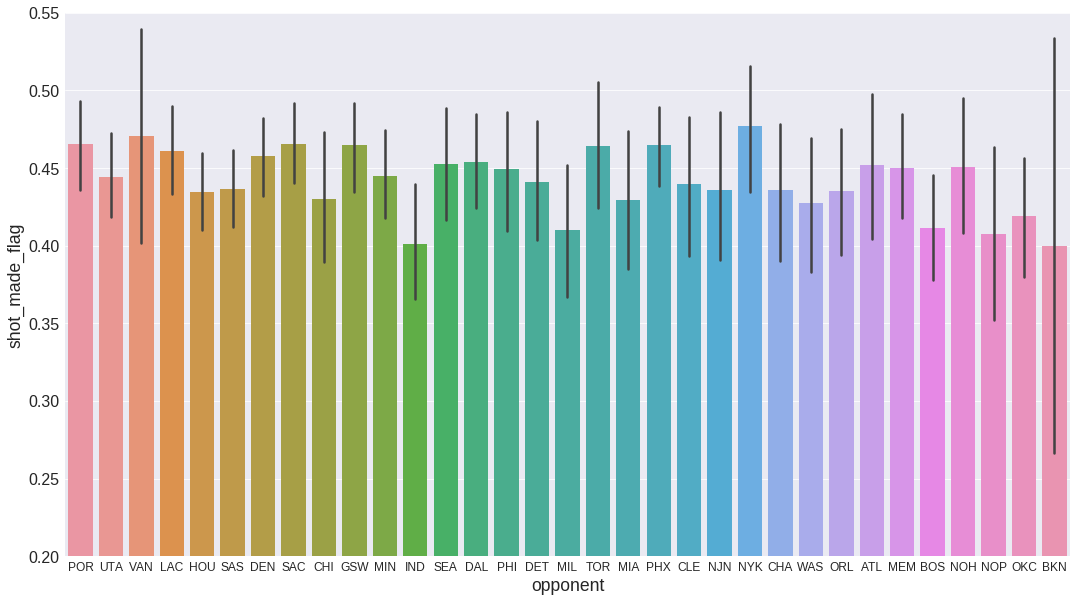

In [24]:
fig = plt.figure(figsize=(18, 10))
sns.barplot(x='opponent', y='shot_made_flag', data=data)
plt.ylim(0.2, 0.55)
plt.xticks(fontsize=12)
plt.show()

It does not seem to be any information here. Kobe's effectivity values against all teams are well within the error bars. Therefore, we won't include this feature in the model.

In [25]:
data.drop('opponent', axis=1, inplace=True)

We simplify game location and opponent information to just get whether Kobe was playing at home or not.

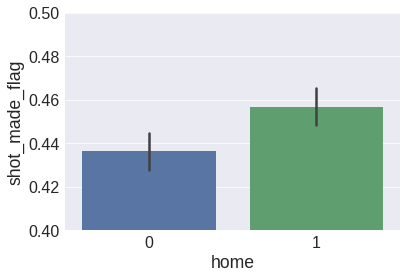

In [26]:
data['home'] = data['matchup'].str.contains('vs').astype(int)
data.drop('matchup', axis=1, inplace=True)

sns.barplot(x='home', y='shot_made_flag', data=data)
plt.ylim(0.4, 0.5)
plt.show()

In contrast to the `playoffs` case, here we see a clear difference between home and away games: Kobe is slightly more effective when at home, and therefore we will keep `home` as a feature.

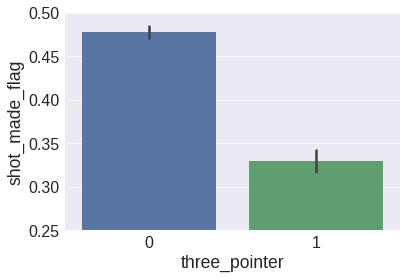

In [27]:
sns.barplot(x='three_pointer', y='shot_made_flag', data=data)
plt.ylim(0.25, 0.5)
plt.show()

As expected, three-point shots have a lower effectivity than two-point shots.

The polar coordinate system offers a more natural representation for the shot location in cartesian coordinates. It will likely lead to a more robust model. Let's transform the coordiantes then.

In [82]:
data['distance'] = np.round(np.sqrt(data.loc_x**2 + data.loc_y**2))
data['angle'] = np.arctan(data.loc_x/data.loc_y)
# data['angle'].fillna(0, inplace=True)

/home/federico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in arctan
  


Let's compare the effectivity of the regular and playoff phases.

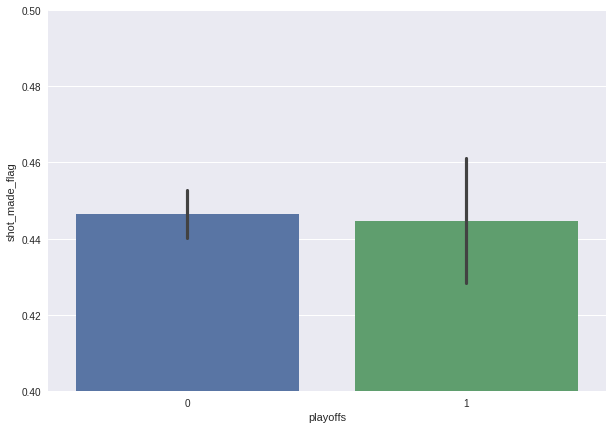

In [32]:
fig = plt.figure(figsize=(10, 7))
sns.barplot(x='playoffs', y='shot_made_flag', data=data)
plt.ylim(0.4, 0.5)
plt.show()

Whether the game is part of the playoffs phase does not seem to affect Kobe's shot effectivity. We can therefore remove this input feature from the dataset.

In [33]:
data.drop('playoffs', axis=1, inplace=True)

In [109]:
data['distance'] = np.round(np.sqrt(data.loc_x**2 + data.loc_y**2))
data['angle'] = np.round(np.arctan(data.loc_x/data.loc_y), 1)

/home/federico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in arctan
  


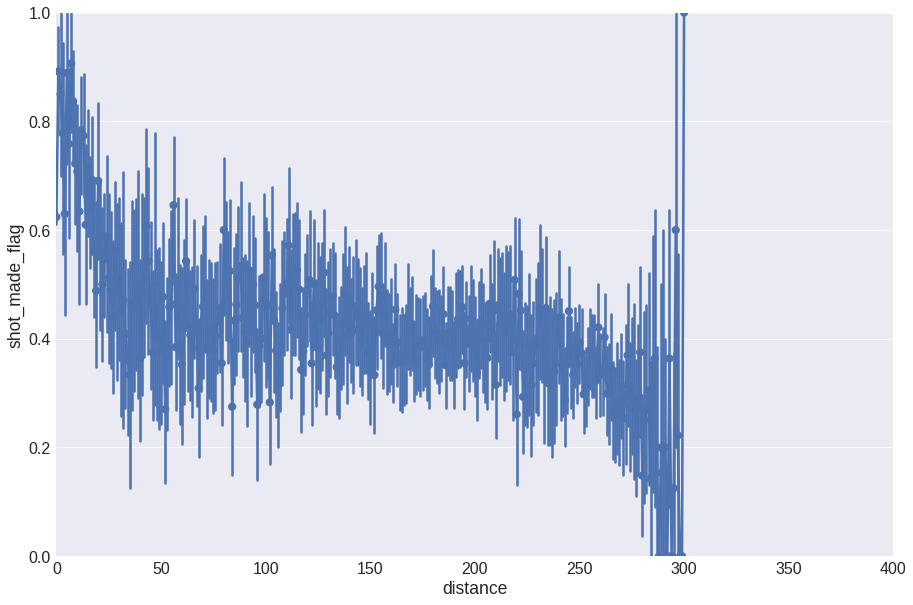

In [110]:
fig = plt.figure(figsize=(15, 10))
sns.pointplot(x='distance', y='shot_made_flag', data=data)
plt.xticks(np.arange(0, 800, 50), np.arange(0, 800, 50))
plt.ylim(0, 1)
plt.xlim(0, 400)
plt.show()

The signal here is very noisy, but if we take a moving average, we see the effectivity peaks at distances closest to the basket and then there is a plateau that transitions into a slow decrease for shots taken far from the basket.

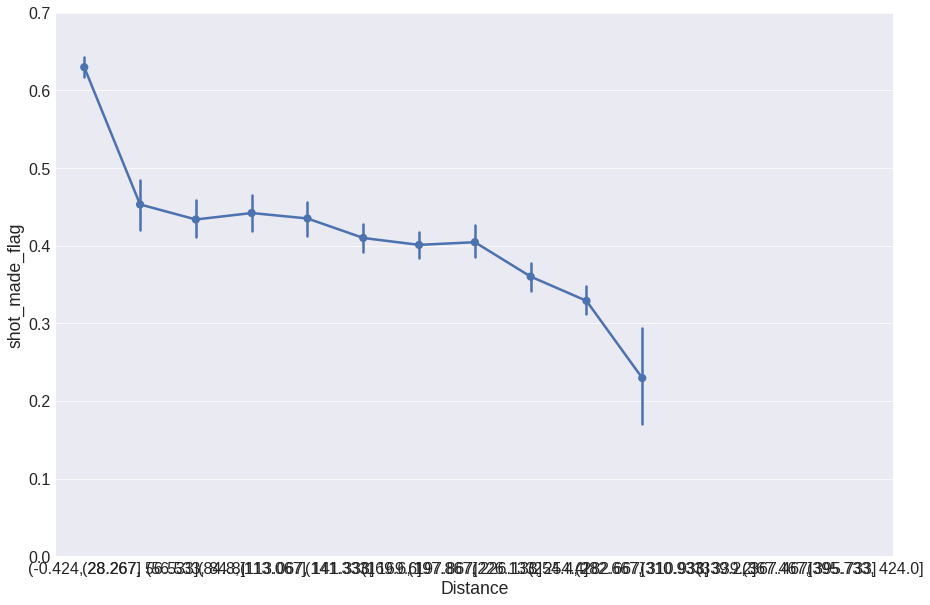

In [114]:
# data[data.distance > 300].distance = 300
fig = plt.figure(figsize=(15, 10))
data['distance_cut'] = pd.cut(data.distance, 15)
sns.pointplot(x='distance_cut', y='shot_made_flag', data=data)
# plt.xlim(0, 140)
plt.xlabel('Distance')
plt.ylim(0, 0.7)
plt.show()

Let's now look at the angle of the shot. This is a very granulated feature, so I prefer to 

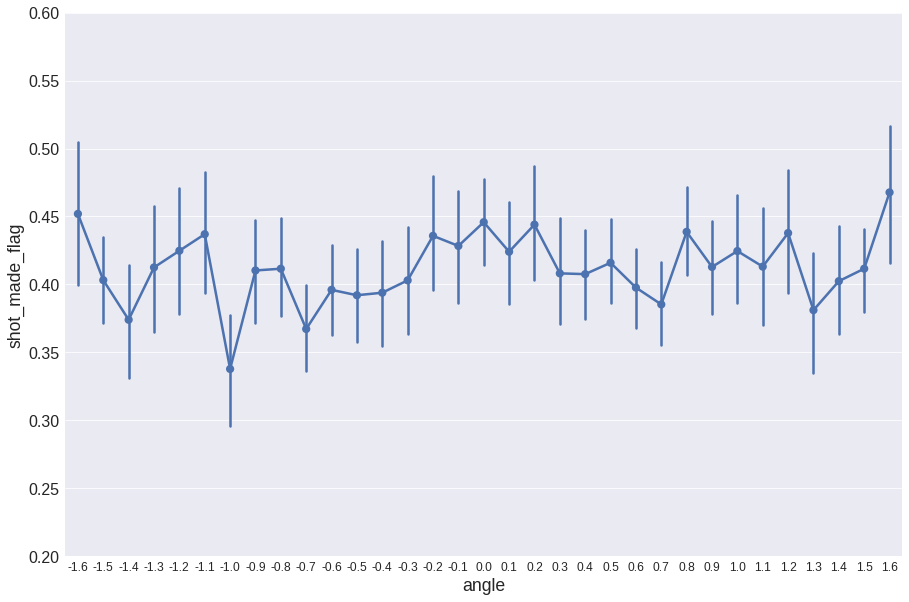

In [91]:
fig = plt.figure(figsize=(15, 10))
sns.pointplot(x=data.angle, y='shot_made_flag', data=data)
plt.xticks(fontsize=12)
plt.ylim(0.2, 0.6)
plt.show()

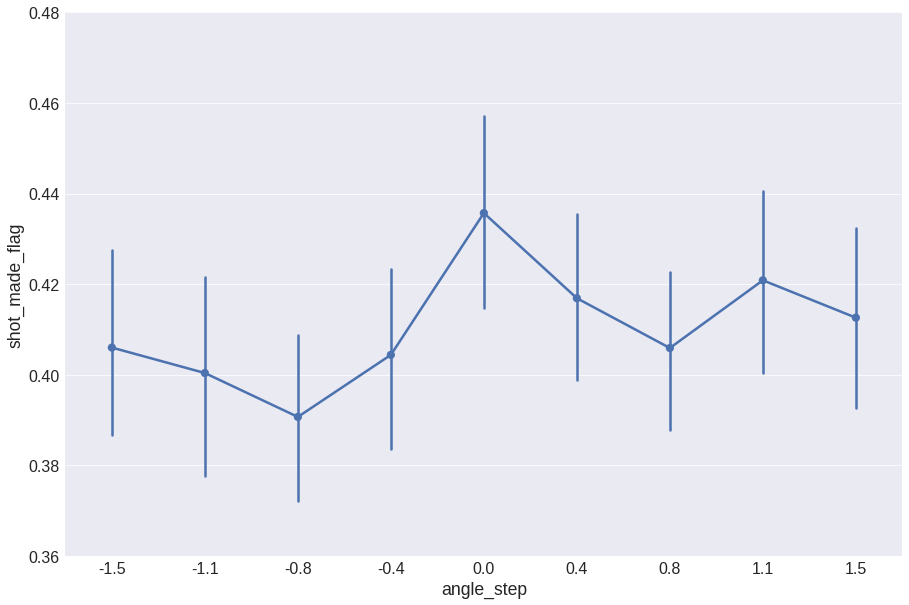

In [87]:
asteps = 9
data['angle_step'] = pd.cut(data.angle, asteps)
fig = plt.figure(figsize=(15, 10))
sns.pointplot(x='angle_step', y='shot_made_flag', data=data)
plt.ylim(0.36, 0.48)
plt.xticks(np.linspace(0, 8, asteps), np.round(np.linspace(-1.5, 1.5, asteps), 1))
plt.show()

We see that the effectivity is slightly higher at `angle = 0` and it seems to be minimum at around 45 degrees. We will keep this 
. 
It seems like a good idea not to include it in our model.

In [160]:
data.drop('angle', axis=1, inplace=True)

In [161]:
data.sample(10)

action_type  loc_x  loc_y  period  season  shot_made_flag  \
19649  Fadeaway Jump    -89    105       2      16             0.0   
22291           Jump    150    213       1      19             0.0   
28602           Jump     12     44       4      12             0.0   
23031           Jump     88    -12       4       0             0.0   
5780           Other      0      0       3       7             1.0   
1296            Jump    148      7       4       4             0.0   
1367    Running Jump   -101     -6       2       4             1.0   
11285  Fadeaway Jump   -115    150       2      10             0.0   
22232           Jump   -160    208       3      19             1.0   
28867          Layup      0      0       2      12             1.0   

                 loc_x_step          loc_y_step  three_pointer  month  \
19649    (-96.154, -83.333]    (96.41, 108.462]              0      1   
22291    (147.436, 160.256]  (204.872, 216.923]              1      3   
28602        (6.41, 19.231]    (36.154, 48.205]              0      6   
23031      (83.333, 96.154]                 NaN              0      3   
5780          (-6.41, 6.41]                 NaN              0      4   
1296     (147.436, 160.256]       (0.0, 12.051]              0      5   
1367    (-108.974, -96.154]                 NaN              0      5   
11285  (-121.795, -108.974]  (144.615, 156.667]              0      6   
22232  (-160.256, -147.436]  (204.872, 216.923]              1      2   
28867         (-6.41, 6.41]                 NaN              0      7   

       time_remaining  home    distance  
19649               4     0  137.644470  
22291               4     0  260.516794  
28602               4     1   45.607017  
23031               4     1   88.814413  
5780                4     0    0.000000  
1296                4     1  148.165448  
1367                4     0  101.178061  
11285               4     0  189.010582  
22232               4     1  262.419511  
28867               4     1    0.000000

This is the result of our exploratory analysis: the dataset containing the most relevant features in relation to the shot effectivity. We will use them to try to predict the outcome with a classification model in the next section.

## Modelling Kobe

### Baseline calculation

Before going any further, it is important to get a baseline result to compare the results of our model to (see [here](https://machinelearningmastery.com/how-to-get-baseline-results-and-why-they-matter/) for a more detailed explanation of why this matters). In this case, we can use the most frequent outcome of Kobe's shots. Sadly, this is Kobe missing the shot. If we would predict a miss for every shot, we would be correct 55% of the time.

In [29]:
1 - data.shot_made_flag.mean()

0.5538389695295171

The model we build here has to perform at least better than this. Let's go then.

### Feature encoding

Based on the analysis of each feature done in the previous section, we split columns into features `X` and target `y` (the shot outcome).

In [30]:
X = data[['action_type', 'period', 'season', 'three_pointer', 'month', 'time_remaining', 'home', 'distance']]
y = data['shot_made_flag']

We need to encode cathegorical features (like `action_type`) into numerical ones, so that they can be picked up by a model. Following [this guide](http://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example):

In [31]:
dummies = pd.get_dummies(X.action_type, prefix='shot', drop_first=True)

X = pd.concat([X, dummies], axis=1)

# now we drop the original action_type column
X.drop(['action_type'], axis=1, inplace=True)

### Modelling with a Random Forest Classifier

Our dataset is now ready to be fed into a model. I was interested in learning more about Random Forests so I chose that model.

First we split data into the train and test sets. Having separate train and test sets is important to check that the model doesn't overfit the data. To know more about the purpose of each set, I recommend [this short article](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7).

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn import metrics

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

I would like to find the best RandomForestClassifier model for this data. This means tuning the hyperparameters that define the model. We will need to create multiple models with different hyperparameters and find out which one works best with our data. However, we can't use the test set for measuring the performance of each model, because doing so would introduce bias when we later want to evaluate the accuracy of our model. Therefore, we need to further split the train set to use a part of it (the **cross-validation** set) for hyperparameter tuning. Fortunately, the `GridSearchCV` function automates this whole process for us. The `fit` method will take different splits of `(X_train, y_train)` and maximize the cross-validation accuracy across all combinations of parameters in `param_grid`. Then we will keep the best parameters to build our final model.

For this section, I will follow the guide in [this excellent blog post](https://www.fabienplisson.com/random-forest-and-grid-search/). Some mode advice on building these kind of models can be found [here](https://stackoverflow.com/questions/20463281/how-do-i-solve-overfitting-in-random-forest-of-python-sklearn) and in the answers to [this question](https://stackoverflow.com/questions/20463281/how-do-i-solve-overfitting-in-random-forest-of-python-sklearn). 

In [33]:
rfc = RandomForestClassifier(n_jobs=-1, max_features='sqrt', oob_score=True) 

# Parameter sweep values
param_grid = {"n_estimators" : [80, 100, 120],
              "max_depth" : [5, 10, 15],
              "min_samples_leaf" : [1, 5, 10]}
CV_rfc = model_selection.GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10)
CV_rfc.fit(X_train, y_train)

print(CV_rfc.best_params_)

{'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 100}


We now build the model using the best parameters we found and we train it with the complete train sets `X_train` and `y_train` to evaluate the performance of the model in the test set. We want to make sure that the model generalizes well, that is, that it does not overfit the data.

In [34]:
seed = 123

# Optimized RF classifier
rfc = RandomForestClassifier(n_estimators=CV_rfc.best_params_['n_estimators'], 
                             max_depth=CV_rfc.best_params_['max_depth'], 
                             min_samples_leaf=CV_rfc.best_params_['min_samples_leaf'], 
                             max_features='sqrt')

kfold = model_selection.KFold(n_splits=10, random_state=seed)

# fit the model with training set
scores = model_selection.cross_val_score(rfc, X_train, y_train, cv=kfold, scoring='accuracy')
print("Train accuracy %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std()*100))

# predict on testing set
preds = model_selection.cross_val_predict(rfc, X_test, y_test, cv=kfold)
print("Test accuracy %0.2f" % (100*metrics.accuracy_score(y_test, preds)))

Train accuracy 68.00 (+/- 0.97)
Test accuracy 68.62


We see that

1. Modelling the data with a RandomForestClassifier model brings the predicting power from the baseline estimation of 55% to a more successful 68%. This corresponds to a 13% improvement. Not so bad!
2. Since the train accuracy matches the test accuracy, we can safely say that the model is not overfitting the data and then it will generalize well to new data.

Now we can build the final model by training with the whole available dataset (see [here](https://machinelearningmastery.com/train-final-machine-learning-model/) for a good explanation as to why this makes sense). Then, we can evaluate the relative importance of features in predicting the outcome of each shot.

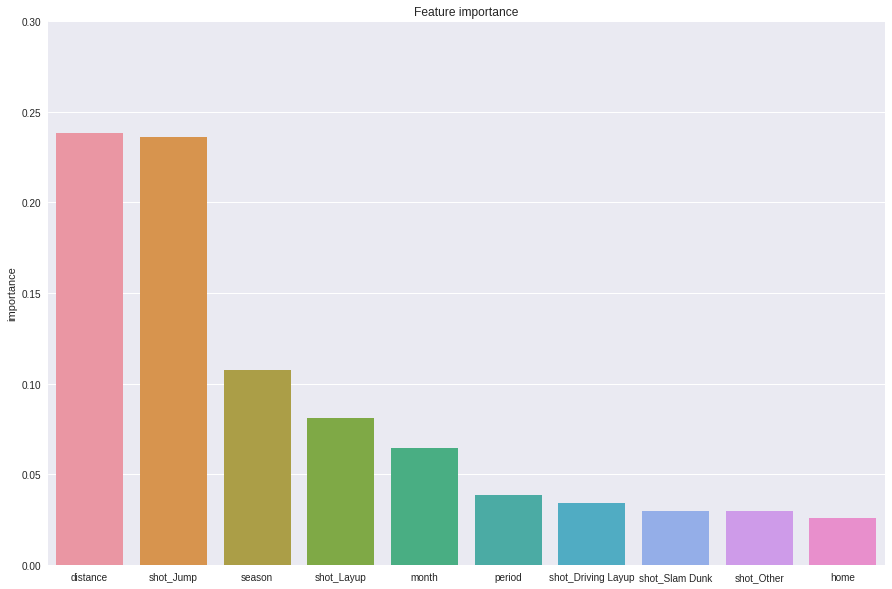

In [35]:
fig = plt.figure(figsize=(15, 10))
rfc.fit(X, y)
feature_importances = pd.DataFrame(rfc.feature_importances_, index=X_train.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)

sns.barplot(feature_importances.index[:10], feature_importances.importance[:10])
plt.title('Feature importance')
plt.ylim(0, 0.3)
plt.show()

Lastly, just for fun I would like to visualize one of the 120 Decision Trees that make up our beloved Random Forest Classifier. Here I am following [this easy guide](https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c).

In [36]:
# Pick one of the trees
estimator = rfc.estimators_[5]

# Export as dot file
from sklearn.tree import export_graphviz
export_graphviz(estimator, out_file='tree.dot', feature_names=X.columns, class_names='shot_made', 
                rounded=True, proportion=False, precision=2, filled=True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
plt.figure(figsize=(15, 10))
Image(filename='tree.png')

<Figure size 1080x720 with 0 Axes>

If you zoom in enough, you will be able to see exactly all the decisions that split the data into predicted misses and predicted hoops. This doesn't give the full picture nor it's really informative but it gives a nice idea of how the model works.

### Final remarks

More things that could be done with this dataset

* Compare these results with what we get with different models.
* Analyse how many features we can remove and still get decent accuracy.

I will leave it like this for now. If you made it this far, thank you! I hope you find some of it useful. If you think I could have done it differently, please leave a comment or contact me through any of the channels, I will be happy to exchange some thoughts.

You can find the jupyter notebook of this post [here](https://fedebarabas.github.io/_posts/2018-04-08-Kobe.ipynb).